<a href="https://colab.research.google.com/github/harvey2phase/rrh-MNIST/blob/main/cnn_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import seaborn as sns

In [2]:
sns.set()

In [3]:
GPU = True
device = torch.device("cuda:0" if GPU and torch.cuda.is_available() else "cpu")

# Load MNIST

In [4]:
MAX_ROT_DEG = 15
BATCH_SIZE = 128

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor()
])
#rot_transform = transforms.RandomRotation(MAX_ROT_DEG)

def load_mnist(train, batch_size = BATCH_SIZE):
    dataset = MNIST(
        root = './data/MNIST',
        download = True,
        train = train,
        transform = img_transform,
    )
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)



In [ ]:
train_dataloader = load_mnist(train = True)
test_dataloader = load_mnist(train = False)

In [6]:
# Place into numpy arrays for easier manipulation
traindata = list(train_dataloader)
traindata = [[sample[0].numpy(), sample[1].numpy()] for sample in traindata]
train_X = np.vstack([sample[0] for sample in traindata])
train_y = np.hstack([sample[1] for sample in traindata])

testdata = list(test_dataloader)
testdata = [[sample[0].numpy(), sample[1].numpy()] for sample in testdata]
test_X = np.vstack([sample[0] for sample in testdata])
test_y = np.hstack([sample[1] for sample in testdata])

# Model Definitions

## CNN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 2.3059, Accuracy: 919/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307193
Train Epoch: 1 [20/60000 (1%)]	Loss: 2.308605
Train Epoch: 1 [40/60000 (2%)]	Loss: 2.312051
Train Epoch: 1 [60/60000 (3%)]	Loss: 2.310634
Train Epoch: 1 [80/60000 (4%)]	Loss: 2.295928
Train Epoch: 1 [100/60000 (5%)]	Loss: 2.291842
Train Epoch: 1 [120/60000 (6%)]	Loss: 2.290722
Train Epoch: 1 [140/60000 (7%)]	Loss: 2.294345
Train Epoch: 1 [160/60000 (9%)]	Loss: 2.303573
Train Epoch: 1 [180/60000 (10%)]	Loss: 2.272862
Train Epoch: 1 [200/60000 (11%)]	Loss: 2.304301
Train Epoch: 1 [220/60000 (12%)]	Loss: 2.294102
Train Epoch: 1 [240/60000 (13%)]	Loss: 2.299315
Train Epoch: 1 [260/60000 (14%)]	Loss: 2.286875
Train Epoch: 1 [280/60000 (15%)]	Loss: 2.276724
Train Epoch: 1 [300/60000 (16%)]	Loss: 2.280898
Train Epoch: 1 [320/60000 (17%)]	Loss: 2.272319
Train Epoch: 1 [340/60000 (18%)]	Loss: 2.245273
Train Epoch: 1 [360/60000 (19%)]	Loss: 2.272908
Train Epoch: 1 [380/60000 (20%)]	Loss: 2.258169


Text(0, 0.5, 'negative log likelihood loss')

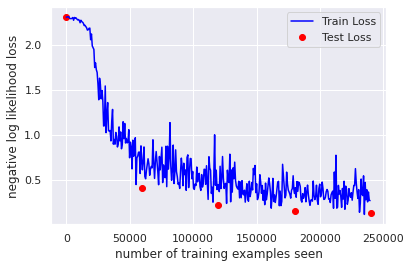

In [9]:
n_epochs = 4
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

train_loader = load_mnist(train = True, batch_size = batch_size_train)
test_loader = load_mnist(train = False, batch_size = batch_size_test)

""" https://nextjournal.com/gkoehler/pytorch-mnist """
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = ConvolutionalNeuralNetwork()
network.to(device)
optimizer = torch.optim.SGD(
    network.parameters(), lr=learning_rate, momentum=momentum,
)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()

    for batch_idx, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        output = network(images)
        loss = F.nll_loss(output, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()
                )
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset))
            )

def test():
    network.eval()

    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            
            output = network(images)
            test_loss += F.nll_loss(output, labels, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        'Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset),
        )
    )

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

### Training and Evaluation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0000, Accuracy: 8554/10000 (86%)


Test set: Avg. loss: 0.0000, Accuracy: 9160/10000 (92%)


Test set: Avg. loss: 0.0000, Accuracy: 9317/10000 (93%)



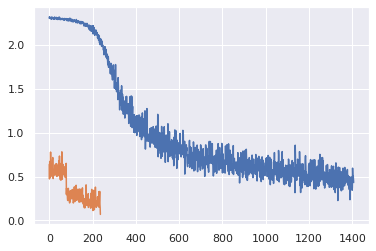

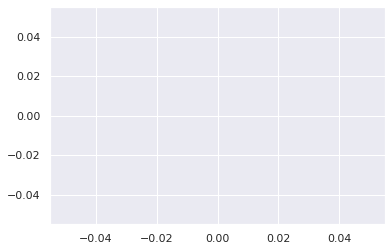

In [75]:
plt.plot(train_losses)


In [ ]:
plt.plot(test_losses)

## VAE

In [ ]:
#SEED = 100

LAT_DIM = 2
EPOCH_NUM = 50
CAPACITY = 64
LRN_RATE = 1e-3
VAR_BETA = 1

KERN_SIZE = 4
STRIDE = 2
PAD = 1

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # CAPACITY * 14 * 14
        self.conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = CAPACITY,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )
        # CAPACITY * 7 * 7
        self.conv2 = nn.Conv2d(
            in_channels = CAPACITY,
            out_channels = CAPACITY * 2,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )
        self.fc_mu = nn.Linear(
            in_features = CAPACITY * 2 * 7 * 7,
            out_features = LAT_DIM,
        )
        self.fc_logvar = nn.Linear(
            in_features = CAPACITY * 2 * 7 * 7,
            out_features = LAT_DIM,
        )
        
    def forward(self, x):
        x = F.relu(self.conv2(
            F.relu(self.conv1(x))
        ))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(
            in_features = LAT_DIM,
            out_features = CAPACITY * 2 * 7 * 7,
        )
        self.conv2 = nn.ConvTranspose2d(
            in_channels = CAPACITY * 2,
            out_channels = CAPACITY,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )
        self.conv1 = nn.ConvTranspose2d(
            in_channels = CAPACITY,
            out_channels = 1,
            kernel_size = KERN_SIZE,
            stride = STRIDE,
            padding = PAD,
        )

    def forward(self, x):
        x = self.fc(x)
        return torch.sigmoid(self.conv1(
                F.relu(self.conv2(
                    x.view(x.size(0), CAPACITY * 2, 7, 7)
            ))
        ))

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [ ]:
def reconstruction_error(recon_x, x):
    return F.binary_cross_entropy(
        recon_x.view(-1, 784),
        x.view(-1, 784),
        reduction = "sum",
    )

def vae_loss(recon_loss, mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + VAR_BETA * kl_divergence

### Training and Evaluation



In [ ]:
def plot_loss(train_losses, test_losses):
    plt.ion()

    plotlabels = ["Total error", "Reconstruction error"]
    
    ncols = 2
    fig, ax = plt.subplots(ncols = ncols, figsize = (9, 2.5))
    
    for i in range(2): 
        ax[i].plot(train_losses[i], c = "blue", label = "training")
        ax[i].plot(test_losses[i], c = "red", label = "test")
            
        ax[i].set_title(plotlabels[i])
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.ylabel(y)
    plt.legend()
    plt.show()

In [ ]:
def eval_model(vae):
    vae.eval()
    
    test_loss_avg, test_recon_loss_avg, num_batches = 0, 0, 0
    sum = 0
    for image_batch, _ in test_dataloader:
        
        with torch.no_grad():
        
            image_batch = image_batch.to(device)
    
            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
    
            # reconstruction error
            recon_loss = reconstruction_error(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
    
            test_recon_loss_avg += recon_loss
            test_loss_avg += loss.item()
            num_batches += 1
        
    test_recon_loss_avg /= num_batches
    test_loss_avg /= num_batches

    return test_recon_loss_avg, test_loss_avg
    #print('average reconstruction error: %f' % (test_recon_loss_avg))
    #print('average error: %f' % (test_loss_avg))

In [ ]:
def train_one_model(evaluate = False):
    """ Creates and trains one VAE model.

    Args:
        evaluate: Whether or not to evaluate model during training.

    Returns:
        Tuple containing the trained model, average training reconstruction
        error, average total training error, average testing reconstruction
        error, and average total testing error.
    """

    #torch.cuda.manual_seed(SEED)
    vae = VariationalAutoencoder()
    vae = vae.to(device)
    
    num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)
    
    optimizer = torch.optim.Adam(
        params = vae.parameters(),
        lr = LRN_RATE,
        weight_decay = 1e-5,
    )
    
    # set to training mode
    vae.train()
    
    if evaluate:
        train_recon_loss, train_loss = [], []
        test_recon_loss, test_loss = [], []
    
    print("Training: ", end = "")
    for epoch in range(EPOCH_NUM):
        if evaluate:
            train_loss.append(0)
            train_recon_loss.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:
            
            image_batch = rot_transform(image_batch)
            image_batch = image_batch.to(device)
    
            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
            
            # reconstruction error
            recon_loss = reconstruction_error(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            if evaluate:
                train_loss[-1] += loss.item()
                train_recon_loss[-1] += recon_loss
                
            num_batches += 1
            
        if evaluate:
            train_loss[-1] /= num_batches
            train_recon_loss[-1] /= num_batches
        
            recon_loss_avg, loss_avg = eval_model(vae)
            test_recon_loss.append(recon_loss_avg)
            test_loss.append(loss_avg)
            vae.train()
        
        print("%d, " % (epoch+1), end = "")
        
    print()
    if evaluate: 
        plot_loss(
            [train_loss, train_recon_loss],
            [test_loss, test_recon_loss],
        )
        
    return vae

In [ ]:
def train_and_test_models(
    n, gamma_matrix, alpha_matrix, beta_matrix, evaluate = False,
):
    """
    Train n models and compute the MNIST heterogeneities on the models.

    Returns:
        Heterogeneity "matrices" that are lists of np arrrays.
        matrix[i] is the heterogeneity array for vae_i
        matrix[i][j] is the heterogeneity for digit_j for vae_i
    """
    for _ in range(n):
        vae = train_one_model(evaluate = evaluate)
        
        gammas, alphas, betas = calculate_rrh(vae)
        gamma_matrix.append(gammas)
        alpha_matrix.append(alphas)
        beta_matrix.append(betas)
    return gamma_matrix, alpha_matrix, beta_matrix

def plot_rrh_matrices(gamma_matrix, alpha_matrix, beta_matrix):
    gamma_avg = het_avg(gamma_matrix)
    alpha_avg = het_avg(alpha_matrix)
    beta_avg = het_avg(beta_matrix)
    
    gamma_sigma = het_sigma(gamma_matrix)
    alpha_sigma = het_sigma(alpha_matrix)
    beta_sigma = het_sigma(beta_matrix)
    
    plot_rrh(
        gamma_avg, alpha_avg, beta_avg,
        sigmas = [gamma_sigma, alpha_sigma, beta_sigma],
    )

## RRH for Gaussian Mixtures

In [ ]:
def mvn_renyi(C, q=1):
    """ Computes the Rényi heterogeneity for a multivariate Gaussian 
    Arguments: 
        C: `ndarray((n,n))`. Covariance matrix
        q: `0<float`. Order of the heterogeneity
    Returns: 
        `float`
    """
    n = C.shape[0]
    SqrtDetC = np.sqrt(np.linalg.det(C))
    if q == 1: 
        out = (2*np.pi*np.e)**(n/2) * SqrtDetC
    elif q == np.inf: 
        out = (2*np.pi)**(n/2) * SqrtDetC
    elif q!=1 and q!=0 and q!=np.inf:
        out = ((2*np.pi)**(n/2))*(q**(n/(2*(q-1))))*SqrtDetC
    return out

In [ ]:
def mvn_renyi_alpha(C,  q=1):
    """ Computes the alpha-heterogeneity for a Gaussian mixture where each sample has equal weight

    Arguments: 

        cov: `ndarray((nsamples, n, n))`. Covariance matrices 
        q: `0<float`. Order of the heterogeneity metric

    Returns: 

        `float`. The alpha-heterogeneity
    """
    K, n, _ = C.shape
    p = np.repeat(1/K, K)
    if q == 1:
        out = np.exp((n + np.sum(p*np.log(np.linalg.det(2*np.pi*C))))/2)
    elif q!=np.inf and q!=1 and q!=0:
        wbar = (p**q)/np.sum(p**q)
        out = ((2*np.pi)**(n/2))*np.sum(wbar*np.sqrt(np.linalg.det(C)))/(q**(n/2))**(1/(1-q))
    return out


In [ ]:
def scale_to_cov(scales):
    return np.vstack([np.expand_dims(np.diagflat(s), 0) for s in scales])

In [ ]:
def pool_covariance(means, covs):
    K = covs.shape[0] 
    p = np.repeat(1/K, K)
    cov_ = np.einsum('ijk,i->jk', covs, p) + np.einsum('ij,ik,i->jk', means, means, p)
    mu_ = np.einsum('ij,i->j', means, p)
    return cov_ - np.einsum('i,j->ij', mu_, mu_)

### Computation and plotting

In [ ]:
def calculate_rrh(vae, X = train_X, y = train_y):
    gammas, alphas, betas = [], [], []
    for i in range(10):
        mu, logvar = vae.encoder(torch.Tensor(X[y == i]).to(device))
        loc = mu.cpu().detach().numpy()
        scale = logvar.exp().cpu().detach().numpy()
        cov = scale_to_cov(scale)
        gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
        alpha = mvn_renyi_alpha(cov,q=1)
        beta = gamma/alpha
        gammas.append(gamma)
        alphas.append(alpha)
        betas.append(beta)
    return np.array(gammas), np.array(alphas), np.array(betas)

In [ ]:
def plot_rrh(gammas, alphas, betas, sigmas = None):
    if not (len(gammas) == len(alphas) or len(gammas) == len(betas)):
        sys.exit("Mismatched matrix size")
    n = len(gammas)
    hetvalues = [gammas, alphas, betas]
    plotlabels = [r"Pooled", r"Within-Observation", r"Between-Observation"]
    
    fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
    ax[0].set_ylabel("Heterogeneity")
    
    for i in range(3): 
        ax[i].set_title(plotlabels[i])
        ax[i].set_xlabel("Digit")
        ax[i].set_xticks(np.arange(10))
        ax[i].set_xticklabels(np.arange(10))
        ax[i].bar(
            np.arange(10),
            hetvalues[i],
            facecolor = plt.get_cmap("Greys")(0.4), 
            edgecolor = "black",
        )
        if not sigmas == None:
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i],
                fmt = "none",
                ecolor = "r",
                capsize = 3,
                label = "std deviation",
            )
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i] / np.sqrt(n),
                fmt = "none",
                ecolor = "b",
                capsize = 3,
                label = "std error",
            )
    plt.tight_layout()
    plt.show()
    #plt.savefig("digit-class-heterogeneity.pdf", bbox_inches="tight")

In [ ]:
def het_sigma(matrix, avg = None):
    if avg == None:
        avg = het_avg(matrix)
    n = len(matrix)
    mse = (matrix[0] - avg) ** 2
    for i in range(1, n):
        mse += (matrix[i] - avg) ** 2
    return np.sqrt(mse / n)

def het_sum(matrix):
    sum = matrix[0] + matrix[1]
    for i in range(2, len(matrix)):
        sum += matrix[i]
    return sum

def het_avg(matrix):
    return het_sum(matrix) / len(matrix)

# Experiments

In [ ]:
"""
N = 1
n = 5
gamma_matrix, alpha_matrix, beta_matrix = [], [], []
for _ in range(N):
    gamma_matrix, alpha_matrix, beta_matrix = train_and_test_models(
        n, gamma_matrix, alpha_matrix, beta_matrix, evaluate = True,
    )
    plot_rrh_matrices(gamma_matrix, alpha_matrix, beta_matrix)
"""

'\nN = 1\nn = 5\ngamma_matrix, alpha_matrix, beta_matrix = [], [], []\nfor _ in range(N):\n    gamma_matrix, alpha_matrix, beta_matrix = train_and_test_models(\n        n, gamma_matrix, alpha_matrix, beta_matrix, evaluate = True,\n    )\n    plot_rrh_matrices(gamma_matrix, alpha_matrix, beta_matrix)\n'

In [ ]:
vae1 = train_one_model()
vae2 = train_one_model()

Number of parameters: 308357
Training: 1, 2, 3, 4, 

KeyboardInterrupt: ignored

## Load, Evaluate, and Plot RRH for Pre-Trained VAE

In [ ]:
def load_pretrained_vae():
    pretrained_vae = VariationalAutoencoder()
    pretrained_vae = pretrained_vae.to(device)
    
    filename = 'vae_2d.pth'
    
    if not os.path.isdir('./pretrained'):
        os.makedirs('./pretrained')
    urllib.request.urlretrieve(
        "http://geometry.cs.ucl.ac.uk/creativeai/pretrained/" + filename,
        "./pretrained/" + filename,
    )
    pretrained_vae.load_state_dict(torch.load('./pretrained/' + filename))
    return pretrained_vae

In [ ]:
pretrained_vae = load_pretrained_vae()
eval_model(pretrained_vae)

(tensor(18493.6641, device='cuda:0'), 19294.807005290742)

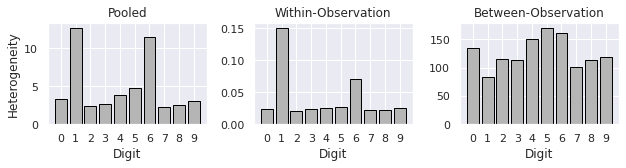

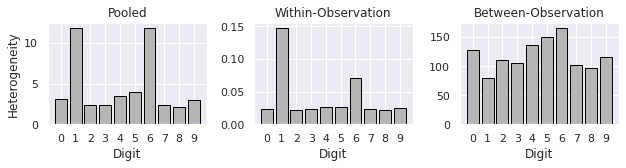

In [ ]:
gammas, alphas, betas = calculate_rrh(pretrained_vae)
plot_rrh(gammas, alphas, betas)

gammas, alphas, betas = calculate_rrh(pretrained_vae, X = test_X, y = test_y)
plot_rrh(gammas, alphas, betas)

In [ ]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_latent_space(vae):
    vae.eval()

    bound = 2.5
    nsteps = 20 
    with torch.no_grad():
        latent_x = np.linspace(-bound,bound,nsteps)
        latent_y = np.linspace(-bound,bound,nsteps)
        latents = torch.FloatTensor(len(latent_x), len(latent_y), 2)
        for i, lx in enumerate(latent_x):
            for j, ly in enumerate(latent_y):
                latents[j, i, 0] = lx
                latents[j, i, 1] = ly
        latents = latents.view(-1, 2) # flatten grid into a batch
    
        # reconstruct images from the latent vectors
        latents = latents.to(device)
        image_recon = vae.decoder(latents)
        image_recon = image_recon.cpu()
    
        fig, ax = plt.subplots(figsize=(10, 10))
        show_image(
            torchvision.utils.make_grid(
                image_recon.data[:int(nsteps**2)], nsteps, 5,
            )
        )
        ax.set_xticks([]); ax.set_xticklabels([])
        ax.set_yticks([]); ax.set_yticklabels([])
        #plt.savefig("latent-space-map.pdf", bbox_inches="tight")



In [ ]:
visualize_latent_space(vae1)

In [ ]:
visualize_latent_space(vae2)

In [ ]:
visualize_latent_space(pretrained_vae)

In [ ]:
def visualise_output(images, model, title = "DEFAULT"):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[0:IMG_NUM], WIDTH, HEIGHT).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.title(title)
        plt.show()

In [ ]:
IMG_NUM = 100
WIDTH = 10
HEIGHT = 10

sns.set(style = "dark")

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[0:IMG_NUM], WIDTH, HEIGHT))
plt.title("Original")
plt.show()


visualise_output(images, vae1, title = "VAE 1")

visualise_output(images, vae2, title = "VAE 2")

visualise_output(images, pretrained_vae, title = "Pretrained VAE")